In [3]:
%pylab inline
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import theano.tensor as T
import theano
plt.style.use(['seaborn-talk'])
plt.rcParams["figure.figsize"] = (10,8)
print(pm.__version__)
print(theano.__version__)

Populating the interactive namespace from numpy and matplotlib
3.5
1.0.2


In [33]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"

In [72]:
generative_ensemble2 = pm.Model()

N = 1000
R = 1000

with generative_ensemble2:
    theta = pm.Beta(name="theta", alpha = 1, beta = 1, shape = (N,))
    lambda_ = pm.HalfNormal(name="lambda", sd = 6.44787, shape = (N,))
    
    failure = pm.Bernoulli(name="failure", logit_p=theta, shape = (N,))
    rate = pm.Poisson(name="rate", mu = lambda_, shape = (N,))
        
    y = pm.Deterministic("y", rate * (1 - failure))

In [73]:
with generative_ensemble2:
    trace = pm.sample_prior_predictive(samples=R)

In [77]:
trace["failure"]

array([[0, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 0, 1]])

In [31]:
trace["theta"]

array([[0.79762782, 0.89855033, 0.98001449, ..., 0.197955  , 0.89200127,
        0.25257009],
       [0.72819473, 0.94294051, 0.56727196, ..., 0.36194756, 0.04095316,
        0.84411106],
       [0.15590906, 0.88257809, 0.59958161, ..., 0.04490845, 0.41727159,
        0.61252831],
       ...,
       [0.7793589 , 0.53479385, 0.96777363, ..., 0.92882499, 0.36562626,
        0.74279071],
       [0.15131182, 0.04563164, 0.23064801, ..., 0.02572568, 0.19913516,
        0.5447918 ],
       [0.7794641 , 0.12856585, 0.94439195, ..., 0.92213073, 0.74222588,
        0.42534542]])

In [75]:
simu_ys = trace["y"]
simu_ys

array([[ 3,  0,  5, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  3,  0, ...,  2,  0,  0],
       ...,
       [ 5,  0,  0, ...,  0,  9,  0],
       [ 0,  0,  1, ..., 13,  0,  0],
       [ 0,  0,  0, ...,  3,  1,  0]])

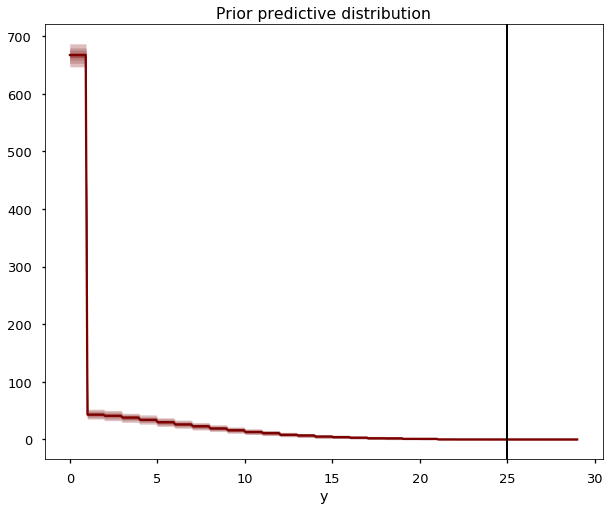

In [76]:
x_max = 30
bins = np.arange(0 ,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simu_ys)

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

In [57]:
simu_ys.shape

(500, 1000)